In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import imagedataextractor as ide
# import other things
import cv2
import copy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [15]:
im_path = './example-image.png'
device = 'cpu'

data = ide.extract(im_path, 
                   seg_bayesian=True,  # Bayesian mode
                   seg_tu=0.0125,  # uncertainty threshold beyond which to filter FPs
                   seg_n_samples=50,  # number of monte carlo samples for Bayesian inference
                   seg_device='cpu'  # set to 'cuda' to utilise GPU.
                  )

2021-04-13 15:01:38,931 : INFO : Input is an image of type png.
2021-04-13 15:01:40,270 : INFO : Scalebar detection failed. Measurements will be given in units of pixels.
2021-04-13 15:01:54,786 : INFO : Particle segmentation successful.
2021-04-13 15:05:03,565 : INFO : Extraction successful - Found 307 particles.


In [16]:
image = cv2.imread(im_path)

In [17]:
# segmentation

seg = data.segmentation.astype(float)
# from imagedataextractor.utils import shuffle_segmap
# seg = shuffle_segmap(seg)
seg[seg == 0] = np.nan  # for visualization purposes
uncertainty = data.uncertainty

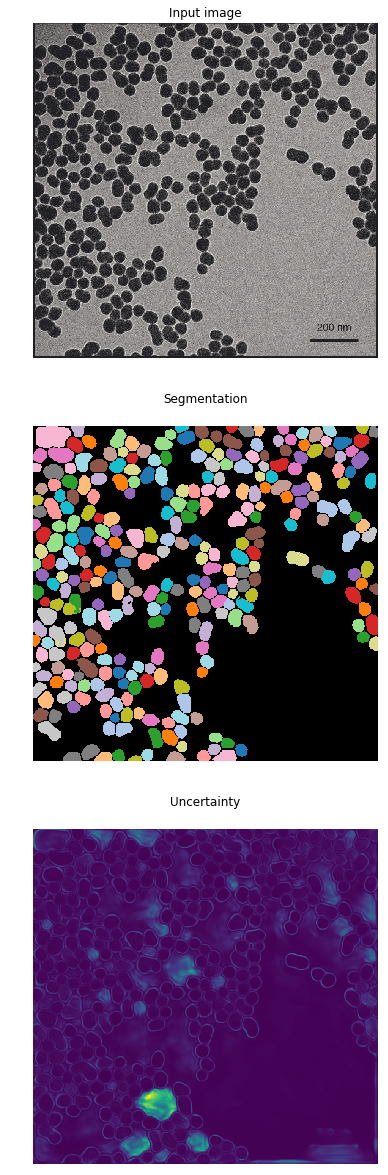

In [18]:
# visualize segmentation an uncertainty

seg_cmap = copy.copy(matplotlib.cm.tab20)
seg_cmap.set_bad(color='k')

fig, axes = plt.subplots(3, 1, figsize=(7, 21))
for ax in axes:
    ax.axis('off')
axes[0].set_title('Input image')
axes[0].imshow(image)
axes[1].set_title('Segmentation')
axes[1].matshow(seg, cmap=seg_cmap)
axes[2].set_title('Uncertainty')
axes[2].matshow(uncertainty)
plt.show()

#### Scalebar

Let's look at the scalebar extraction results.

In [19]:
# scalebar conversion

sb_text = data.scalebar.text
conversion = data.scalebar.conversion

sb_text, conversion

('200 nm', 1.5584415584415584e-09)

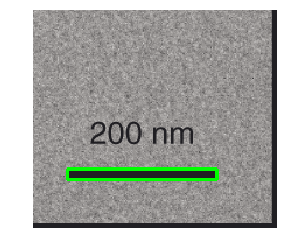

In [20]:
sb_image = cv2.drawContours(image, [data.scalebar.scalebar_contour], 0, (0, 255, 0), 2)

plt.imshow(sb_image[700:, 700:])
plt.axis('off')
plt.show()

It looks like the scalebar was read and measured correctly.

#### Extracted Data

Let's view the data as a pandas `DataFrame`.

In [21]:
df = data.to_pandas()
df.head()

,idx,center,edge,contours,area (pixels^2),area,area_units,aspect_ratio,shape_estimate,diameter,diameter_units,original_units,uncertainty
0,1,"[124, 835]",False,"[[[[831 109]], [[831 110]], [[830 111]], [[827...",741,1.799696e-15,meters^2,0.909091,circle,4.786904e-08,meters,nm,0.004609
1,2,"[362, 236]",False,"[[[[231 346]], [[231 347]], [[230 348]], [[227...",990,2.404453e-15,meters^2,1.400000,None,NaN,meters,nm,0.004609
2,3,"[858, 548]",False,"[[[[541 842]], [[541 843]], [[540 844]], [[538...",897,2.178580e-15,meters^2,0.942857,circle,5.266739e-08,meters,nm,0.004609
3,4,"[132, 301]",False,"[[[[302 109]], [[302 110]], [[301 111]], [[298...",1363,3.310373e-15,meters^2,0.829787,None,NaN,meters,nm,0.004610
4,5,"[180, 351]",False,"[[[[346 163]], [[346 164]], [[345 165]], [[341...",1008,2.448170e-15,meters^2,0.921053,circle,5.583106e-08,meters,nm,0.004610


#### Particle Sizes

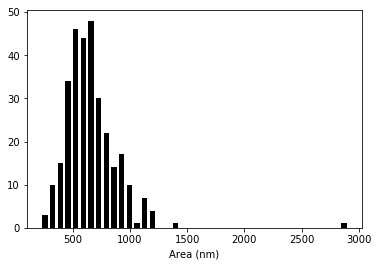

In [22]:
sizes = df['area (pixels^2)'].to_numpy() # These are in units of pixels^2.

# Let's use our scalebar conversion to convert to nanometers.
sizes = sizes / conversion  # to meters
sizes = sizes * 1e-9  # to nanometers

plt.hist(sizes, bins=40, color='k', rwidth=0.7)
plt.xlabel('Area (nm)')
plt.show()

In [23]:
print('Average particle size: {:.3f} nm    std deviation: {:.3f} nm'.format(np.mean(sizes), np.std(sizes)))

Average particle size: 655.257 nm    std deviation: 232.851 nm


#### Particle Coordinates

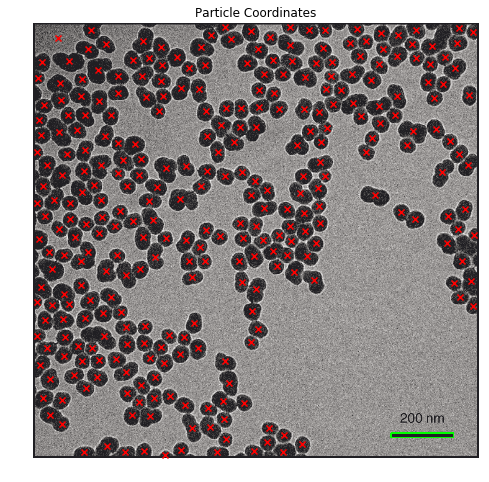

In [24]:
coords = data.coords

plt.figure(figsize=(8, 8))
plt.title('Particle Coordinates')
plt.imshow(image)
plt.scatter(coords[:, 1], coords[:, 0], marker='x', color='r')
plt.axis('off')
plt.show()

We can obtain particle coordinates from the `center` column of the pandas DataFrame. However, if we intend to use the coords to compute a radial distribution function (RDF), we don't want the coords of particles which are touching the edge of the image, as these can bias the RDF. We can use `data.valid_coords` to obtain only the coordinates of valid particles (those that don't exist on the edge).

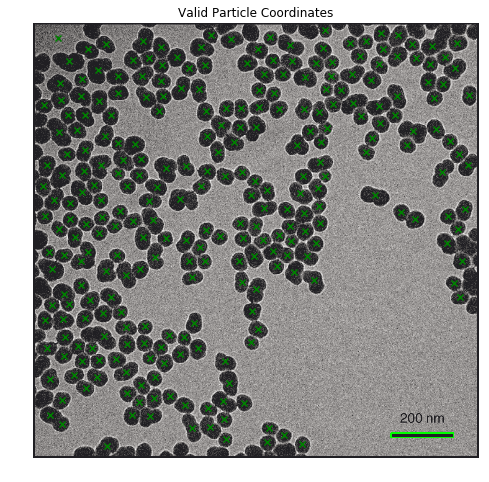

In [25]:
valid_coords = data.valid_coords

plt.figure(figsize=(8, 8))
plt.title('Valid Particle Coordinates')
plt.imshow(image)
plt.scatter(valid_coords[:, 1], valid_coords[:, 0], marker='x', color='green')
plt.axis('off')
plt.show()

#### Radial Distribution Function

#### Method 1: Using imagedataextractor

We can compute the radial distribution function using the `compute_rdf()` method of the `EMData` object.

In [26]:
dr = 5  # set our step size to 5 nm
g_r, radii = data.compute_rdf(dr=dr)

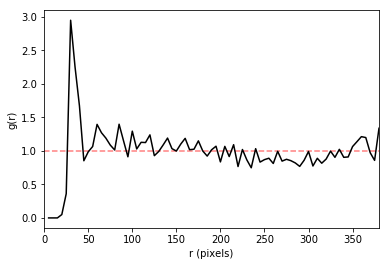

In [27]:
# visualize RDF

plt.plot(radii, g_r, color='k')
plt.hlines(1.0, 0.0, radii.max(), color='r', linestyle='--', alpha=0.5)
plt.xlim(0.0, radii.max())
plt.xlabel('r (pixels)')
plt.ylabel('g(r)')
plt.show()

#### Method 2: Using rdfpy

In [28]:
from imagedataextractor.analysis import rdf2d

# Let's use our scalebar conversion to convert to nanometers.
valid_coords = valid_coords / conversion  # to meters
valid_coords = valid_coords * 1e-9  # to nanometers

dr = 2.5  # nm

g_r, radii = rdf2d(valid_coords, dr=dr)

This method is more flexible, as we can convert the coords to nanometers if we wish. We should obtain the same result as before.

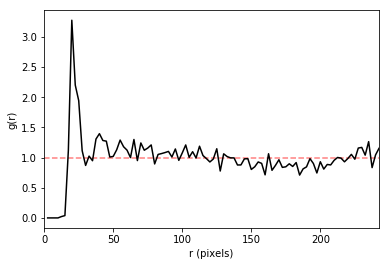

In [29]:
# visualize RDF

plt.plot(radii, g_r, color='k')
plt.hlines(1.0, 0.0, radii.max(), color='r', linestyle='--', alpha=0.5)
plt.xlim(0.0, radii.max())
plt.xlabel('r (pixels)')
plt.ylabel('g(r)')
plt.show()